# EE5907 Programming Assignment Q1
Lee Jianwei
A0018867

In [38]:
from __future__ import division
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
np.set_printoptions(precision=2, suppress=True)

# Data Processing

### Load

In [39]:
d = scipy.io.loadmat('spamData.mat')
# print d.items()

In [40]:
ytest = d['ytest'].flatten()
ytrain = d['ytrain'].flatten()
xtest = d['Xtest']
xtrain = d['Xtrain']

In [41]:
len(ytest)

1536

In [42]:
len(ytrain)

3065

### Binarize

In [43]:
def binarize(array):
    """array: list of emails, each 57 features long"""
    return np.array([x>0 for x in array]).astype('uint8') #x is a 57 element array

In [44]:
xtrainBin = binarize(xtrain)
xtestBin = binarize(xtest)
print xtrainBin
print xtrainBin.shape

print xtrainBin[:,0]
print len(xtrain[0])

[[0 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [0 1 1 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]
 [0 0 0 ..., 1 1 1]]
(3065, 57)
[0 0 1 ..., 0 0 0]
57


In [45]:
# remove last 3 features which doesn't help in the binarized data case
xtrainBin = np.delete(xtrainBin,np.s_[-3:],axis=1)
xtestBin = np.delete(xtestBin,np.s_[-3:],axis=1)
print xtrainBin.shape

(3065, 54)


# Q1

In [46]:
classMLE = np.average(ytrain)
print classMLE

0.389885807504


In [47]:
np.average(ytest)

0.40234375

In [48]:
alphas = np.arange(0,100.5,0.5)

In [49]:
def N_feature_trainBin(spam): # N_jc in notes
    """
    returns an array of N's, 
    each N is the total number of times a binarised feature appears
    in the training data
    :params spam: either 1 (spam) or 0 
    """
    return np.sum(xtrainBin[ytrain==spam],axis=0)

def N_class_train(spam): # N_c in notes
    """
    returns the total number of mails categorised as spam or not.
    :params spam: either 1 (spam) or 0 
    """
    return len(ytrain[ytrain==spam])

N_feature_trainBin = [N_feature_trainBin(0),N_feature_trainBin(1)]
N_class_train = [N_class_train(0), N_class_train(1)]

def posterior_predictive_mean(spam, alpha): # theta_jc in notes
    """
    returns an array of posterior predictive means
    :params spam: either 1 (spam) or 0 
    :params alpha: hyperparameter alpha for beta distribution
    """
    return (N_feature_trainBin[spam]+alpha)/(N_class_train[spam]+2*alpha)

In [50]:
print('feature likelihood for spam training data')
print np.mean(xtrainBin[ytrain==1], axis=0)

feature likelihood for spam training data
[ 0.35  0.35  0.62  0.02  0.64  0.37  0.44  0.33  0.29  0.46  0.31  0.63
  0.28  0.13  0.16  0.56  0.37  0.38  0.89  0.21  0.81  0.05  0.33  0.38
  0.03  0.01  0.    0.01  0.01  0.01  0.    0.    0.04  0.01  0.02  0.06
  0.06  0.02  0.03  0.12  0.    0.01  0.05  0.03  0.27  0.04  0.01  0.01
  0.15  0.65  0.07  0.84  0.6   0.29]


In [51]:
print('percentage uncertainty between posterior mean and training data likelihood for spam mails')

(posterior_predictive_mean(1,0)-\
 np.mean(xtrainBin[ytrain==1], axis=0))/\
np.mean(xtrainBin[ytrain==1], axis=0)*100 # check with above

percentage uncertainty between posterior mean and training data likelihood for spam mails


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

In [52]:
def classify(email, alpha):
    """
    classifies each email according to the posterior predictive means of the features
    :params email: 57-element binarised array
    :params posterior_predictive_mean: 57-element array of the posterior means derived 
    from a particular alpha and the training data
    """
    N_features = len(email)
    
    SecondTerm_Spam = 0
    SecondTerm_notSpam = 0
    
    for j in np.arange(N_features): # second term in p(y=c | x, T) in notes
        
        SecondTerm_Spam += (email[j]==1)*np.log(posterior_predictive_mean(1,alpha)[j]) +\
        (email[j]==0)*np.log(1-posterior_predictive_mean(1,alpha)[j])
        
        SecondTerm_notSpam += (email[j]==1)*np.log(posterior_predictive_mean(0,alpha)[j]) +\
        (email[j]==0)*np.log(1-posterior_predictive_mean(0,alpha)[j])
        
    LogProb_Spam = np.log(classMLE) + SecondTerm_Spam
    
    LogProb_notSpam = np.log(1-classMLE) + SecondTerm_notSpam
    
    class_ = (LogProb_Spam > LogProb_notSpam).astype('uint8')
#     print class_
    return class_

## Error rate for test data

In [53]:
def error_rate(alpha):
    N_errors = 0
    for idx,mail in enumerate(xtestBin):
        N_errors += np.logical_xor(classify(mail,alpha), ytest[idx])
    return N_errors/len(xtestBin)
#         print classify(mail,alpha), ytest[idx]
#     return [np.abs(classify(mail,posterior_predictive_mean(alpha))-ytest[idx]) for idx,mail in enumerate(xtestBin)]

In [54]:
error_rates = Pool(4).map(error_rate, alphas)

In [64]:
# np.savetxt('q1_testing_error_rates_vs_alpha', zip(error_rates,alphas), header='error_rate\talpha')

In [8]:
# error_rates,alphas = np.loadtxt('q1_testing_error_rates_vs_alpha').T

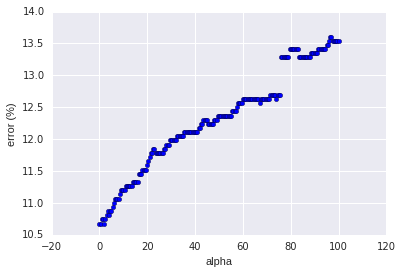

In [62]:
%matplotlib inline
plt.figure()
plt.scatter(alphas, np.array(error_rates)*100)
plt.xlabel('alpha')
plt.ylabel('error (%)')
# plt.xlim(0,10)
plt.show()

## Error rate for training data

In [65]:
def error_rate_training(alpha):
    N_errors = 0
    for idx, mail in enumerate(xtrainBin):
        N_errors += np.logical_xor(classify(mail,alpha), ytrain[idx])
    return N_errors/len(xtrainBin)

In [66]:
error_rates_training = Pool(4).map(error_rate_training, alphas)

In [70]:
# np.savetxt('q1_training_error_rates_vs_alpha', zip(error_rates_training,alphas), header='error_rate_training\talpha')

In [6]:
# error_rates_training,alphas = np.loadtxt('q1_training_error_rates_vs_alpha').T

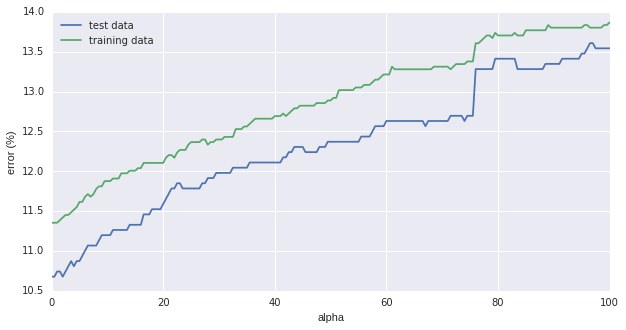

In [71]:
import seaborn
%matplotlib inline
plt.figure(figsize = (10,5))
plt.plot(alphas, np.array(error_rates)*100, label='test data')
plt.plot(alphas, np.array(error_rates_training)*100, label='training data')
plt.xlabel('alpha')
plt.ylabel('error (%)')
plt.legend(loc='best')
plt.show()

In [28]:
print [error_rates_training[alphas==a]*100 for a in [1,10,100]]
print [error_rates[alphas==a]*100 for a in [1,10,100]]

[array([ 11.35]), array([ 11.88]), array([ 13.87])]
[array([ 10.74]), array([ 11.2]), array([ 13.54])]


# Observations
error rate increases with alpha for both training and test data

# Training and test data error rates for alpha = 1, 10, 100

In [72]:
map(error_rate, np.array([1,10,100]))

[0.107421875, 0.11197916666666667, 0.13541666666666666]

In [24]:
map(error_rate_training, np.array([1,10,100]))

[0.1135399673735726, 0.11876019575856443, 0.13866231647634583]